## a

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence

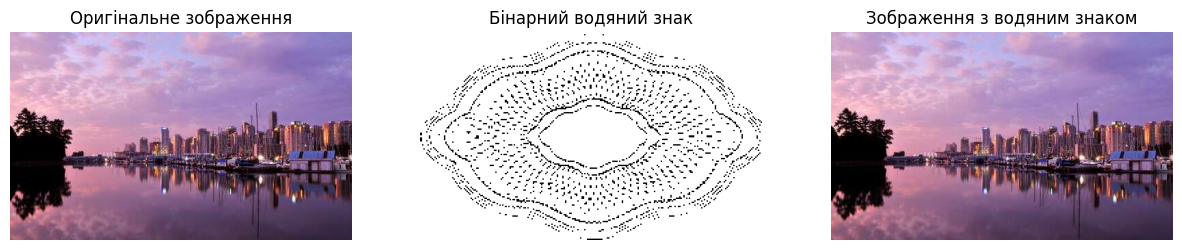

In [47]:
container_path = "container.jpg"
watermark_path = "watermark.png"

container = cv2.imread(container_path)
watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)

_, binary_watermark = cv2.threshold(watermark, 128, 1, cv2.THRESH_BINARY)

wm_resized = cv2.resize(binary_watermark, (container.shape[1], container.shape[0]), interpolation=cv2.INTER_NEAREST)

blue_channel = container[:, :, 0].copy()
blue_channel = (blue_channel & 0b11111110) | wm_resized.astype(np.uint8)  

stego_image = container.copy()
stego_image[:, :, 0] = blue_channel
cv2.imwrite("stego_image.png", stego_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(container, cv2.COLOR_BGR2RGB))
axs[0].set_title("Оригінальне зображення")
axs[0].axis("off")

axs[1].imshow(wm_resized * 255, cmap="gray") 
axs[1].set_title("Бінарний водяний знак")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB))
axs[2].set_title("Зображення з водяним знаком")
axs[2].axis("off")

plt.show()


## b

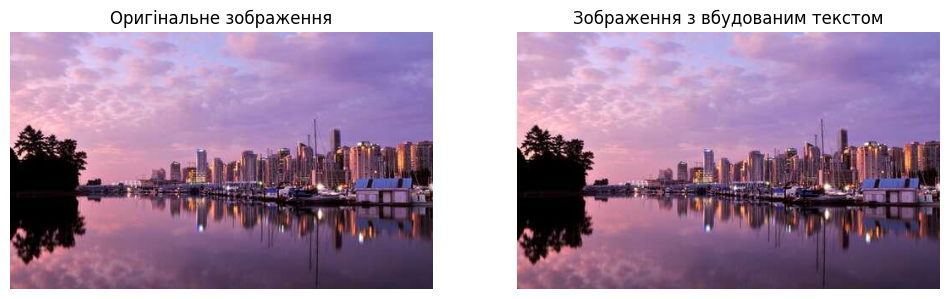

In [48]:
def text_to_bits(text):
    return ''.join(format(ord(char), '08b') for char in text) + '00000000'  

container = cv2.imread("container.jpg")

text = "Hello, student!"  
bits = text_to_bits(text)  

max_bits = container.shape[0] * container.shape[1]  
if len(bits) > max_bits:
    raise ValueError("Текст занадто довгий для вбудовування в це зображення")

blue_channel = container[:, :, 0].flatten()  
for i, bit in enumerate(bits):
    blue_channel[i] = (blue_channel[i] & 0b11111110) | int(bit)  

stego_image = container.copy()
stego_image[:, :, 0] = blue_channel.reshape(container.shape[:2])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(cv2.cvtColor(container, cv2.COLOR_BGR2RGB))
axs[0].set_title("Оригінальне зображення")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB))
axs[1].set_title("Зображення з вбудованим текстом")
axs[1].axis("off")

plt.show()


## c

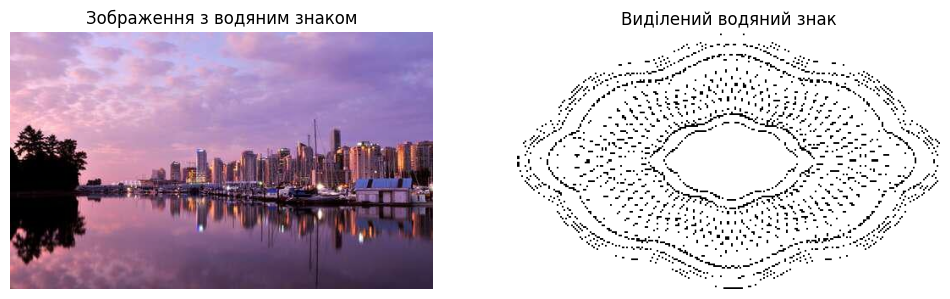

In [49]:
stego_image = cv2.imread("stego_image.png")

blue_channel = stego_image[:, :, 0]

extracted_watermark = blue_channel & 1 

extracted_watermark = extracted_watermark * 255

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Зображення з водяним знаком")
axs[0].axis("off")

axs[1].imshow(extracted_watermark, cmap="gray")
axs[1].set_title("Виділений водяний знак")
axs[1].axis("off")

plt.show()


## d

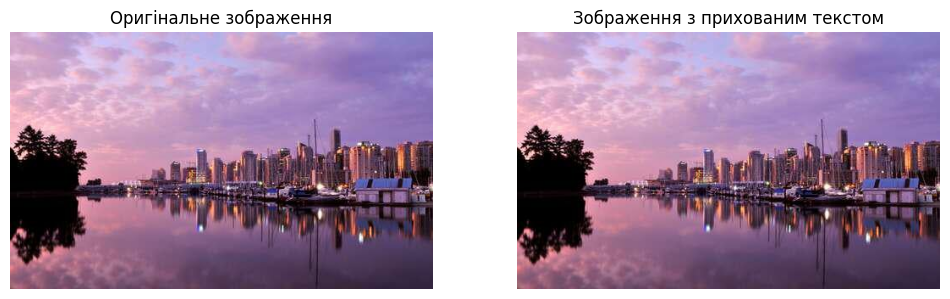

In [50]:
def text_to_bits(text):
    return ''.join(format(ord(char), '08b') for char in text) + '00000000'  

def embed_text(image, text):
    bits = text_to_bits(text)
    img = image.copy()
    
    blue_channel = img[:, :, 0].flatten() 

    if len(bits) > len(blue_channel):
        raise ValueError("Текст занадто довгий для вбудовування")

    for i, bit in enumerate(bits):
        blue_channel[i] = (blue_channel[i] & 0b11111110) | int(bit)

    img[:, :, 0] = blue_channel.reshape(image.shape[:2])  
    return img

container = cv2.imread("container.jpg")


text = "Hello, student!!" 
stego_image = embed_text(container, text)  


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(cv2.cvtColor(container, cv2.COLOR_BGR2RGB))
axs[0].set_title("Оригінальне зображення")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB))
axs[1].set_title("Зображення з прихованим текстом")
axs[1].axis("off")

plt.show()


Код для вилучення тексту із зображення:

In [51]:
def bits_to_text(bits):
    chars = [bits[i:i+8] for i in range(0, len(bits), 8)]
    text = ''
    for char in chars:
        if char == '00000000': 
            break
        text += chr(int(char, 2))
    return text

def extract_text(image):
    blue_channel = image[:, :, 0].flatten()  
    bits = ''.join(str(pixel & 1) for pixel in blue_channel) 
    return bits_to_text(bits) 

extracted_text = extract_text(stego_image)
print("Вилучений текст:", extracted_text)


Вилучений текст: Hello, student!!


## e.

In [52]:
import wave

def audio_to_binary(audio_path):
    with wave.open(audio_path, 'rb') as audio:
        frames = audio.readframes(audio.getnframes())
    binary_data = ''.join(format(byte, '08b') for byte in frames)
    return binary_data

def binary_to_audio(binary_data, output_path, params):
    audio_bytes = bytearray(int(binary_data[i:i+8], 2) for i in range(0, len(binary_data), 8))
    with wave.open(output_path, 'wb') as audio:
        audio.setparams(params)
        audio.writeframes(audio_bytes)

def embed_audio_in_image(image_path, audio_path, output_image):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    h, w, _ = img.shape
    binary_data = audio_to_binary(audio_path)
    
    if len(binary_data) > h * w * 3:
        raise ValueError("Аудіо занадто велике для цього зображення")
    
    idx = 0
    for i in range(h):
        for j in range(w):
            for k in range(3):
                if idx < len(binary_data):
                    img[i, j, k] = (img[i, j, k] & 0xFE) | int(binary_data[idx])
                    idx += 1
                else:
                    break
    cv2.imwrite(output_image, img)

def extract_audio_from_image(image_path, output_audio, params):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    binary_data = ''
    for row in img:
        for pixel in row:
            for channel in pixel:
                binary_data += str(channel & 1)
    
    binary_to_audio(binary_data, output_audio, params)





image_file = "container.jpg" 
audio_file = "audio.wav"  
output_image = "encoded_image.png" 
output_audio = "extracted_audio.wav" 

with wave.open(audio_file, 'rb') as audio:
    params = audio.getparams()

embed_audio_in_image(image_file, audio_file, output_image)
extract_audio_from_image(output_image, output_audio, params)

## f

In [53]:
def embed_image(container, watermark):
    img = container.copy()
    
    wm_resized = cv2.resize(watermark, (container.shape[1], container.shape[0]))

    for channel in range(3):  
        img[:, :, channel] = (img[:, :, channel] & 0b11111110) | (wm_resized[:, :, channel] >> 7)

    return img


container = cv2.imread("container.jpg")
watermark = cv2.imread("watermark.png")

frames = []
for i in range(8):
    modified_container = cv2.convertScaleAbs(container, alpha=1, beta=i*5)
    stego_image = embed_image(modified_container, watermark)
    
    pil_frame = Image.fromarray(cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB))
    frames.append(pil_frame)

gif_path = "stego_gif.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)

print(f"GIF-файл збережено")


GIF-файл збережено


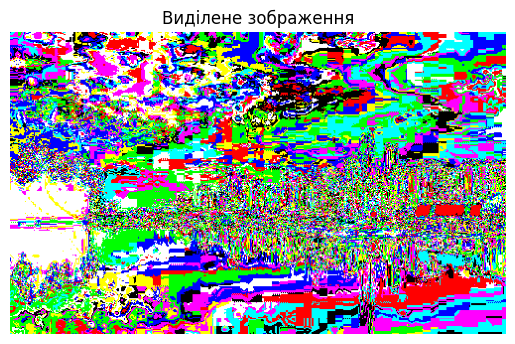

In [54]:
def extract_image_from_gif(gif_path):
    gif = Image.open(gif_path)
    first_frame = np.array(gif.convert("RGB"))

    extracted_image = np.zeros_like(first_frame)
    for channel in range(3): 
        extracted_image[:, :, channel] = (first_frame[:, :, channel] & 1) * 255  

    return extracted_image

extracted_image = extract_image_from_gif(gif_path)

plt.imshow(cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB))
plt.title("Виділене зображення")
plt.axis("off")
plt.show()
